In [1]:
import os
import time
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import *

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.callbacks import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'E:\\Data\\60k_splitted_1D_STFT_dataset\\'
os.chdir(path)
path

'E:\\Data\\60k_splitted_1D_STFT_dataset\\'

In [3]:
TRAINING_DIR = path+"/train"
VALIDATION_DIR = path + "/val"
TEST_DIR = path + "/test"

print(TRAINING_DIR)
print(VALIDATION_DIR)
print(TEST_DIR)

E:\Data\60k_splitted_1D_STFT_dataset\/train
E:\Data\60k_splitted_1D_STFT_dataset\/val
E:\Data\60k_splitted_1D_STFT_dataset\/test


In [4]:
def data_loader(path):
    X = []
    Y = []
    for folder in os.listdir(path):
        for file in os.listdir(os.path.join(path, folder)):
            feature = np.load(os.path.join(path, folder, file))
            label = folder
            X += feature.tolist()
            Y += [label]*feature.shape[0]
    return X, Y

In [5]:
X_train, Y_train = data_loader(TRAINING_DIR)
X_val, Y_val = data_loader(VALIDATION_DIR)
X_test, Y_test = data_loader(TEST_DIR)

In [6]:
print("There are {} training samples and {} training labels".format(len(X_train), len(Y_train)))
print("There are {} validation samples and {} validation labels".format(len(X_val), len(Y_val)))
print("There are {} testing samples and {} testing labels".format(len(X_test), len(Y_test)))

There are 39999 training samples and 39999 training labels
There are 10000 validation samples and 10000 validation labels
There are 10000 testing samples and 10000 testing labels


In [7]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)

print("Shape of X_train: {}".format(X_train.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of Y_train: {}".format(Y_train.shape))
print("Shape of Y_val: {}".format(Y_val.shape))
print("Shape of Y_test: {}".format(Y_test.shape))

Shape of X_train: (39999, 1026)
Shape of X_val: (10000, 1026)
Shape of X_test: (10000, 1026)
Shape of Y_train: (39999,)
Shape of Y_val: (10000,)
Shape of Y_test: (10000,)


In [8]:
X_train[0].shape

(1026,)

In [9]:
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_val = label_encoder.fit_transform(Y_val)
Y_test = label_encoder.fit_transform(Y_test)
print(np.unique(Y_train))

std = StandardScaler()
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_val = std_scaler.transform(X_val)
X_test = std_scaler.transform(X_test)
print(X_train[0:5, 0:5])

[0 1]
[[ 0.40628541  3.78169554  4.04695586  1.03432937 -0.04790825]
 [-0.46005958 -0.38086726 -0.36792094 -0.36358415 -0.47579487]
 [-0.45699692 -0.44642912 -0.43478414 -0.44837834 -0.30542466]
 [-0.43140387 -0.3899724  -0.41988362 -0.43899126 -0.38878485]
 [ 0.03303411 -0.07867876 -0.29721826 -0.4269852  -0.44703661]]


In [10]:
# shuffle the dataset
shuffle_index = np.random.permutation(len(X_train))
X_train, Y_train = X_train[shuffle_index], Y_train[shuffle_index]
shuffle_index = np.random.permutation(len(X_val))
X_val, Y_val = X_val[shuffle_index], Y_val[shuffle_index]
shuffle_index = np.random.permutation(len(X_test))
X_test, Y_test = X_test[shuffle_index], Y_test[shuffle_index]

In [11]:
# Reshape the input data
X_train = X_train.reshape( (X_train.shape[0], X_train.shape[1], 1) )
X_val = X_val.reshape( (X_val.shape[0], X_val.shape[1], 1) )
X_test = X_test.reshape( (X_test.shape[0], X_test.shape[1], 1) )
Y_train = Y_train.reshape( (Y_train.shape[0], 1) )
Y_val = Y_val.reshape( (Y_val.shape[0], 1) )
Y_test = Y_test.reshape( (Y_test.shape[0], 1) )

print("Shape of X_train: {}".format(X_train.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of Y_train: {}".format(Y_train.shape))
print("Shape of Y_val: {}".format(Y_val.shape))
print("Shape of Y_test: {}".format(Y_test.shape))

Shape of X_train: (39999, 1026, 1)
Shape of X_val: (10000, 1026, 1)
Shape of X_test: (10000, 1026, 1)
Shape of Y_train: (39999, 1)
Shape of Y_val: (10000, 1)
Shape of Y_test: (10000, 1)


# Model 1:

In [12]:
model = Sequential([
    layers.Input(shape=(X_train.shape[1:])),
    layers.Conv1D(16, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(256, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(512, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1024, 16)          64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 512, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 510, 32)           1568      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 255, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 253, 64)           6208      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 126, 64)          0

In [14]:
earlystopper = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

In [15]:
epochs = 300
batch_size = 32
current_time = int(time.time())
stop_training_callback = earlystopper
history = model.fit(X_train, Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(X_val, Y_val), 
                    callbacks=[stop_training_callback])
print("Training completed in {} seconds.".format(int(time.time()-current_time)))

Epoch 1/300
1250/1250 [==============================] - 30s 20ms/step - loss: 0.3958 - accuracy: 0.7995 - val_loss: 0.2325 - val_accuracy: 0.9023
Epoch 2/300
1250/1250 [==============================] - 25s 20ms/step - loss: 0.1927 - accuracy: 0.9176 - val_loss: 0.1559 - val_accuracy: 0.9380
Epoch 3/300
1250/1250 [==============================] - 25s 20ms/step - loss: 0.1406 - accuracy: 0.9416 - val_loss: 0.1095 - val_accuracy: 0.9556
Epoch 4/300
1250/1250 [==============================] - 25s 20ms/step - loss: 0.1093 - accuracy: 0.9561 - val_loss: 0.1096 - val_accuracy: 0.9575
Epoch 5/300
1250/1250 [==============================] - 25s 20ms/step - loss: 0.0880 - accuracy: 0.9644 - val_loss: 0.0798 - val_accuracy: 0.9688
Epoch 6/300
1250/1250 [==============================] - 25s 20ms/step - loss: 0.0734 - accuracy: 0.9701 - val_loss: 0.0771 - val_accuracy: 0.9695
Epoch 7/300
1250/1250 [==============================] - 25s 20ms/step - loss: 0.0616 - accuracy: 0.9764 - val_loss: 0

In [16]:
best_epoch = np.argmin(np.array(history.history['val_loss']))

In [17]:
# def plot_history(history, label):
#     plt.figure(figsize=(10, 6))
#     plt.plot(history.history[label], label=label)
#     plt.plot(history.history['val_'+label], label='val_'+label)
#     plt.ylim([0, 0.5])
#     best_epoch = np.argmin(history.history['val_'+label]) + 1
#     plt.axvline(best_epoch, linestyle='dashed')
#     plt.xlabel('Epoch')
#     plt.ylabel(label.title())
#     plt.legend()
#     plt.grid(True)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


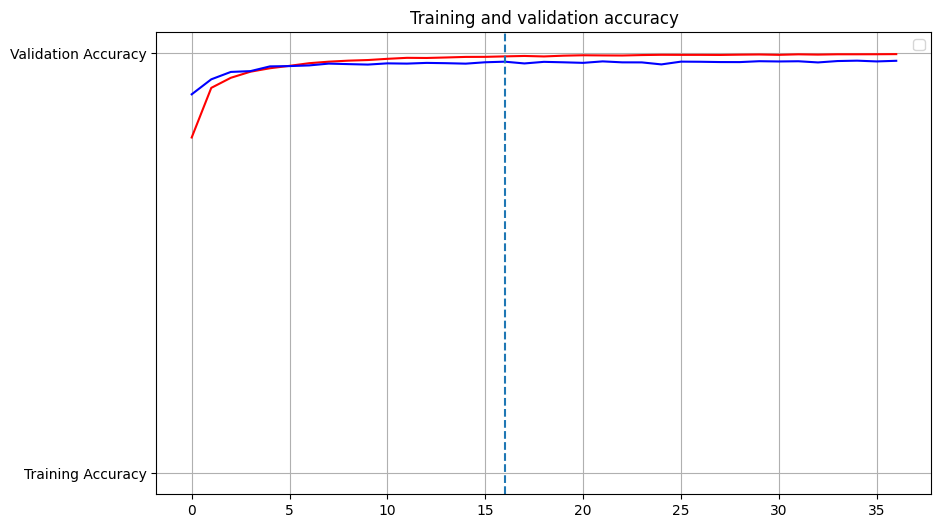

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


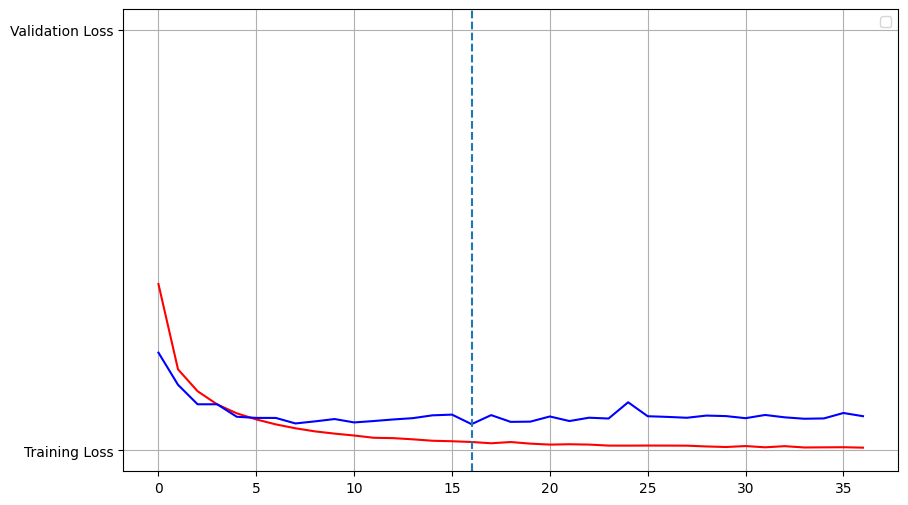

In [18]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.axvline(best_epoch, linestyle='dashed')
plt.title('Training and validation accuracy')
plt.legend()
plt.grid(True)
plt.show()
print("")
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.axvline(best_epoch, linestyle='dashed')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
test_predict = model.predict(X_test)
test_score = roc_auc_score(Y_test, test_predict)
print(f"StackNet AUC on testing set: {round(test_score, 4)}")

313/313 [==============================] - 1s 3ms/step
StackNet AUC on testing set: 0.998


In [20]:
show_test_predict = np.round(test_predict, 0)
show_test_predict = pd.DataFrame(show_test_predict)
print(show_test_predict[0:10])
print(len(show_test_predict))

     0
0  1.0
1  1.0
2  0.0
3  1.0
4  1.0
5  1.0
6  0.0
7  0.0
8  0.0
9  0.0
10000


In [32]:
def plot_confusion_matrix(cm, title):
    df_cm = pd.DataFrame(cm, index = [i for i in ['Queen', 'Queenless']],
                    columns = [i for i in ['Queen', 'Queenless']])
    df_cm_normed = df_cm/df_cm.sum()
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, fmt="", )
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title + ".png")
    plt.show()

def plot_roc_curve(Y_test, test_predict, title):
    fpr, tpr, thresholds = roc_curve(Y_test, test_predict)

    aucc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label="ROC curve (area = {0:.4f})".format(aucc))
    plt.plot([0, 1], [0, 1], linestyle="dashed")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.savefig(title + ".png")
    plt.legend()
    plt.show()

In [22]:
# fpr, tpr, thresholds = roc_curve(Y_test, test_predict)
# roc_auc = auc(fpr, tpr)

# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)'% roc_auc)
# plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0,1.0])
# plt.ylim([0.0,1.05])
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend(loc="lower right")
# plt.show()

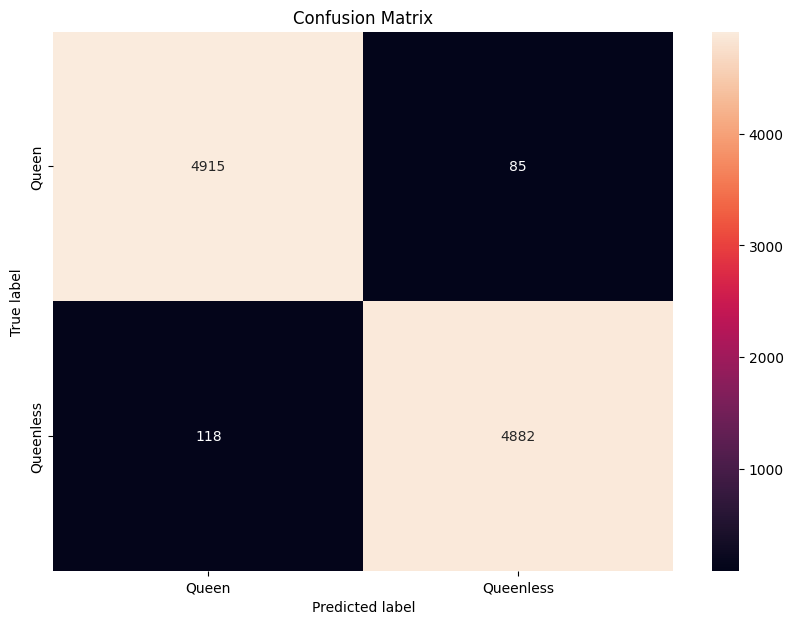

In [33]:
cm = confusion_matrix(Y_test, show_test_predict)
plot_confusion_matrix(cm, "Confusion Matrix")

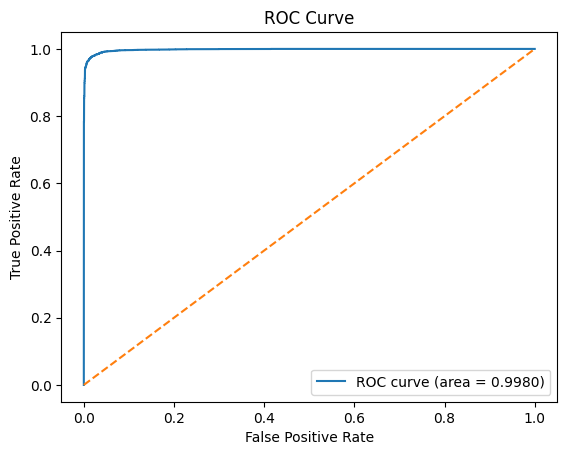

In [34]:
plot_roc_curve(Y_test, test_predict, "ROC Curve")

In [25]:
from sklearn.metrics import f1_score
f1_score(Y_test, show_test_predict, average='macro')

0.9796997789305926

In [26]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(Y_test, show_test_predict)
display(cf)

array([[4915,   85],
       [ 118, 4882]], dtype=int64)

In [27]:
stt = model.evaluate(X_test, Y_test)
print(stt)

313/313 [==============================] - 1s 4ms/step - loss: 0.0620 - accuracy: 0.9797
[0.06202443689107895, 0.9797000288963318]


In [28]:
print(classification_report(Y_test, show_test_predict))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5000
           1       0.98      0.98      0.98      5000

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [31]:
os.getcwd()

'E:\\Data\\60k_splitted_1D_STFT_dataset'

In [30]:
model.save("1D_STFT_CNN_model_98.h5")

# Model 2: Reduce learning rate

In [ ]:
model = Sequential([
    layers.Input(shape=(X_train.shape[1:])),
    layers.Conv1D(16, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(256, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(512, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
earlystopper = EarlyStopping(
    monitor='val_loss',
    patience=100,
    restore_best_weights=True
)

In [ ]:
epochs = 1000
batch_size = 32
current_time = int(time.time())
stop_training_callback = earlystopper
history = model.fit(X_train, Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(X_val, Y_val), 
                    callbacks=[stop_training_callback])
print("Training completed in {} seconds.".format(int(time.time()-current_time)))

In [ ]:
best_epoch = np.argmin(np.array(history.history['val_loss']))

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.axvline(best_epoch, linestyle='dashed')
plt.title('Training and validation accuracy')
plt.show()
print("")
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.axvline(best_epoch, linestyle='dashed')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_predict = model.predict(X_test)
test_score = roc_auc_score(Y_test, test_predict)
print(f"StackNet AUC on testing set: {round(test_score, 4)}")

In [ ]:
stt = model.evaluate(X_test, Y_test)
print(stt)

In [ ]:
cm = confusion_matrix(Y_test, show_test_predict)
plot_confusion_matrix(cm, "Confusion Matrix")

In [ ]:
plot_roc_curve(Y_test, test_predict, "ROC Curve")

In [ ]:
print(classification_report(Y_test, show_test_predict))